In [55]:
from bioscrape.lineage import LineageModel, LineageVolumeSplitter #For building our Model
from bioscrape.lineage import py_SimulateInteractingCellLineage, py_PropagateInteractingCells
from bioscrape.types import Model
import numpy as np
import pylab as plt
# import time as pytime
from time import process_time 

In [56]:
#A global model with no reactions is just a container for ahl signal
global_x0 = {"S":0}

rxng = []

Mglobal = Model(species = ["S"], reactions = [], initial_condition_dict = global_x0)

In [57]:
# cell 1 reactions

#Species: A list of all the species
species = ["S", "T", "T:S", "G", "T:S:G", "P", "T:S:G:P", "M", "R", "M:R", "GFP"]

#Params
params = [("kahlbind", 100), ("kahlunb", 1), 
          ("ktfbind", 50), ("ktfunb", 10), 
          ("kpolbind", 50), ("kpolunb", 2), 
          ("kribbind", 40), ("kribunb", 10),
          ("ktx", 2), ("ktl", 5), ("delta", .0005),
         ("kahl", 1), ("ahldeg", 0)]

ps = {x[0]:x[1] for x in params} #so you can get the actual values to plug them into the reactions



#Reactions: A list of reactions [rxn1, rxn2...]. Each reaction is a tuple ([Input Species], [Output Species], "propensity_type", {propensity_parameters})
#you have to put the actual parameter value in the propensity params since lineage model doesn't take a params list

#make and degrade signal
rxnS = ([], ["S"], "massaction", {"k":ps["kahl"]})
rxnDegS = (["S"], [], "massaction", {"k":ps["ahldeg"]}) #cells will degrade signal and we'll also have an optional
                                                    #environmental degradation reaction in the global compartment

#ahl binds and unbinds transcription factor
rxnAHL = (["T", "S"], ["T:S"], "massaction", {"k":ps["kahlbind"]})
rxnAHL0 = (["T:S"], ["T", "S"], "massaction", {"k":ps["kahlunb"]})

#active transcription factor binds dna
rxnDNA = (["T:S", "G"], ["T:S:G"], "massaction", {"k":ps["ktfbind"]})
rxnDNA0 = (["T:S:G"], ["T:S", "G"], "massaction", {"k":ps["ktfunb"]})

#DNA transcription factor complex binds polymerase
rxnPol = (["T:S:G", "P"], ["T:S:G:P"], "massaction", {"k":ps["kpolbind"]})
rxnPol0 = (["T:S:G:P"], ["T:S:G", "P"], "massaction", {"k":ps["kpolunb"]})

#transcription
rxnTx = (["T:S:G:P"], ["T:S:G", "P", "M"], "massaction", {"k":ps["ktx"]})
rxnDegM = (["M"], [], "massaction", {"k":ps["delta"]})

#ribosome binds mrna
rxnRib = (["M", "R"], ["M:R"], "massaction", {"k":ps["kribbind"]})
rxnRib0 = (["M:R"], ["M", "R"], "massaction", {"k":ps["kribunb"]})

#Translation
rxntl = (["M:R"], ["M", "R", "GFP"], "massaction", {"k":ps["ktl"]})
rxnDegGFP = (["GFP"], [], "massaction", {"k":ps["delta"]})



reactions = [rxnS, rxnDegS, rxnAHL, rxnAHL0, rxnDNA, rxnDNA0, rxnPol, rxnPol0,
             rxnTx, rxnRib, rxnRib0, rxntl, rxnDegS, rxnDegGFP, rxnDegM]


#An initial condition for each species (uninitialized species default to 0)

# species = ["S", "T", "T:S", "G", "TSG", "TSG:P", "M", "R", "M:R", "GFP"]

x0 = {
    "T":10,
    "G":1,
    "P":25,
    "R":100,
    "S":0,
    "T:S":0,
    "T:S:G":0,
    "T:S:G:P":0,
    "M":0,
    "M:R":0,
    "GFP":0
}

In [58]:
# general cell growth params

#Use the Same Parameters for both cell types
ke = 1.
g = .01
kgrow = 100
Kgrow = 10
kdeath = 1.0
Kdeath = 100

In [59]:
#cell 1 model

Mcell1 = LineageModel(species = species, reactions = reactions, initial_condition_dict = x0)

vsplit = LineageVolumeSplitter(Mcell1, options = {"G":"duplicate", "T":"duplicate", "P":"duplicate", "R":"duplicate"})
Mcell1.create_division_rule("deltaV", {"threshold":1.0}, vsplit)


# I think this can be used to make a logistic type growth
Mcell1.create_volume_event("linear volume", {"growth_rate":g}, "massaction", {"k":0.2, "species":"R"})

#Too much toxin/gfp and the cell dies
Mcell1.create_death_event("death", {}, "hillpositive", {"k":kdeath, "s1":"GFP", "n":2, "K":Kdeath})

#Initialize the model (this also a)
Mcell1.py_initialize()

In [60]:
# set up the simulation

maxtime = 1000
dt = 0.01
global_sync_period = .5
global_volume = 100

timepoints = np.arange(0, maxtime+dt, dt)

average_dist_threshold = 2.
global_species = ["S"]
model_list = [Mcell1]
initial_cell_counts = [2]

In [61]:
print("Simulating")
ts = process_time()



lineage_list, global_results, simulator = py_SimulateInteractingCellLineage(timepoints, global_sync_period, global_volume = global_volume,
                                                 model_list = model_list, global_volume_model = Mglobal,
                                                 initial_cell_states = initial_cell_counts, 
                                                 global_species = global_species, 
                                                 average_dist_threshold = average_dist_threshold)

#Instead of simulating a whole cell Lineage, use propogate cells to get snapshots over time
# Nsamples = 1000
# sample_list, sample_times, global_results, simulator = py_PropagateInteractingCells(timepoints, global_sync_period, 
#                                                  sample_times = Nsamples, global_volume = global_volume,
#                                                  model_list = model_list, global_volume_model = Mglobal,
#                                                  initial_cell_states = initial_cell_counts, 
#                                                  global_species = global_species, 
#                                                  average_dist_threshold = average_dist_threshold)

te = process_time()
print("Simulation Complete in", te-ts, "s")

# print("N cell 1:", [len(L[0]) for L in sample_list])

Simulating


C:\Users\geeze\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Total cell volume exceeded global volume. All cells set to dead and simulation terminated.
  # Remove the CWD from sys.path while we load stuff.


Simulation Complete in 1.84375 s


In [62]:
sch_tree = lineage_list[0].get_schnitzes_by_generation()

In [64]:
sch_tree[5][-1].py_get_dataframe(Model = Mcell1)

,S,T,T:S,G,T:S:G,P,T:S:G:P,M,R,M:R,GFP,time,volume
0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,98.0,0.0,1.0,25.83,0.798034
1,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,98.0,0.0,1.0,25.84,0.798034
2,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,98.0,0.0,1.0,25.85,0.798034
3,1.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,98.0,0.0,1.0,25.86,0.798034
4,1.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,98.0,0.0,1.0,25.87,0.798034
...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,4.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,98.0,0.0,1.0,31.00,1.778034
528,3.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,98.0,0.0,1.0,31.00,1.778034
529,3.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,98.0,0.0,1.0,31.01,1.778034
530,3.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,98.0,0.0,1.0,31.02,1.788034


Plotting


Text(0, 0.5, 'LacI - TetR')

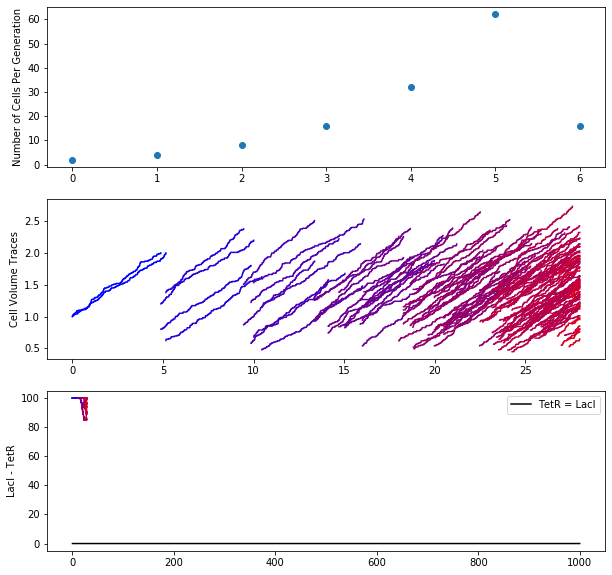

In [23]:
# A little plotting
color_list = [(i/len(sch_tree), 0, 1.-i/len(sch_tree)) for i in range(len(sch_tree))]

print("Plotting")
plt.figure(figsize = (10, 10))
#Plot Generation Counts
plt.subplot(311)
plt.plot(range(len(sch_tree)), [len(L) for L in sch_tree], "o")
plt.ylabel("Number of Cells Per Generation")

#Plot Volume Traces
plt.subplot(312)
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch in L:
        df = sch.py_get_dataframe(Model = Mcell1)
        plt.plot(df["time"], df["volume"], color = color_list[generation])
plt.ylabel("Cell Volume Traces")

#Plot lacI
plt.subplot(313)
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch in L:
        df = sch.py_get_dataframe(Model = Mcell1)
        plt.plot(df["time"], df["R"], color = color_list[generation])

plt.plot(timepoints, np.zeros(len(timepoints)), ms = "5", color = "black", label = "TetR = LacI")
plt.legend()
plt.ylabel("LacI - TetR")
